In [54]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
train_fp = "train.csv"
train_df = pd.read_csv(train_fp)
train_df = train_df.drop('Id', axis=1)
print(train_df.head(3))
train_df.info()

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  

[3 rows x 80 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Cou

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


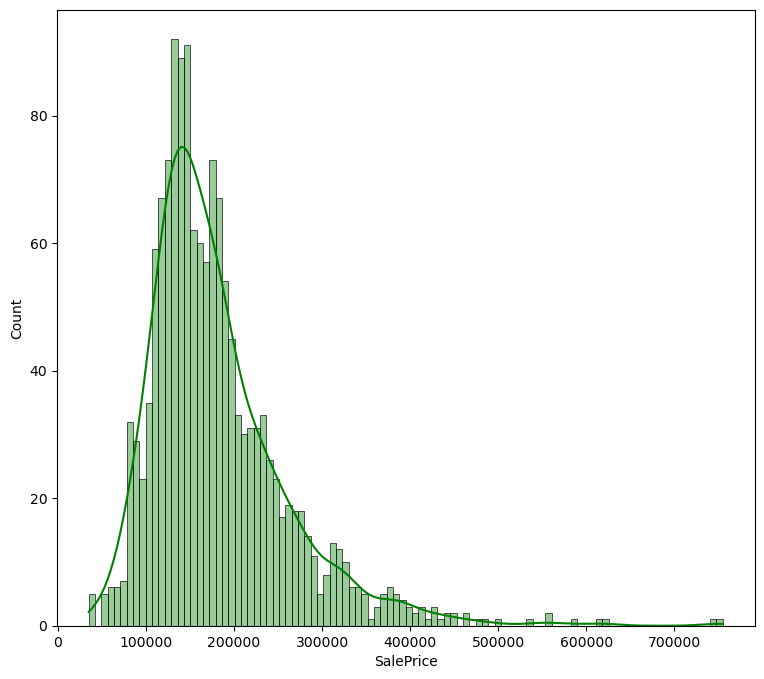

In [56]:
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(train_df['SalePrice'], color='g', bins=100, kde=True, alpha=0.4)
plt.show()

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

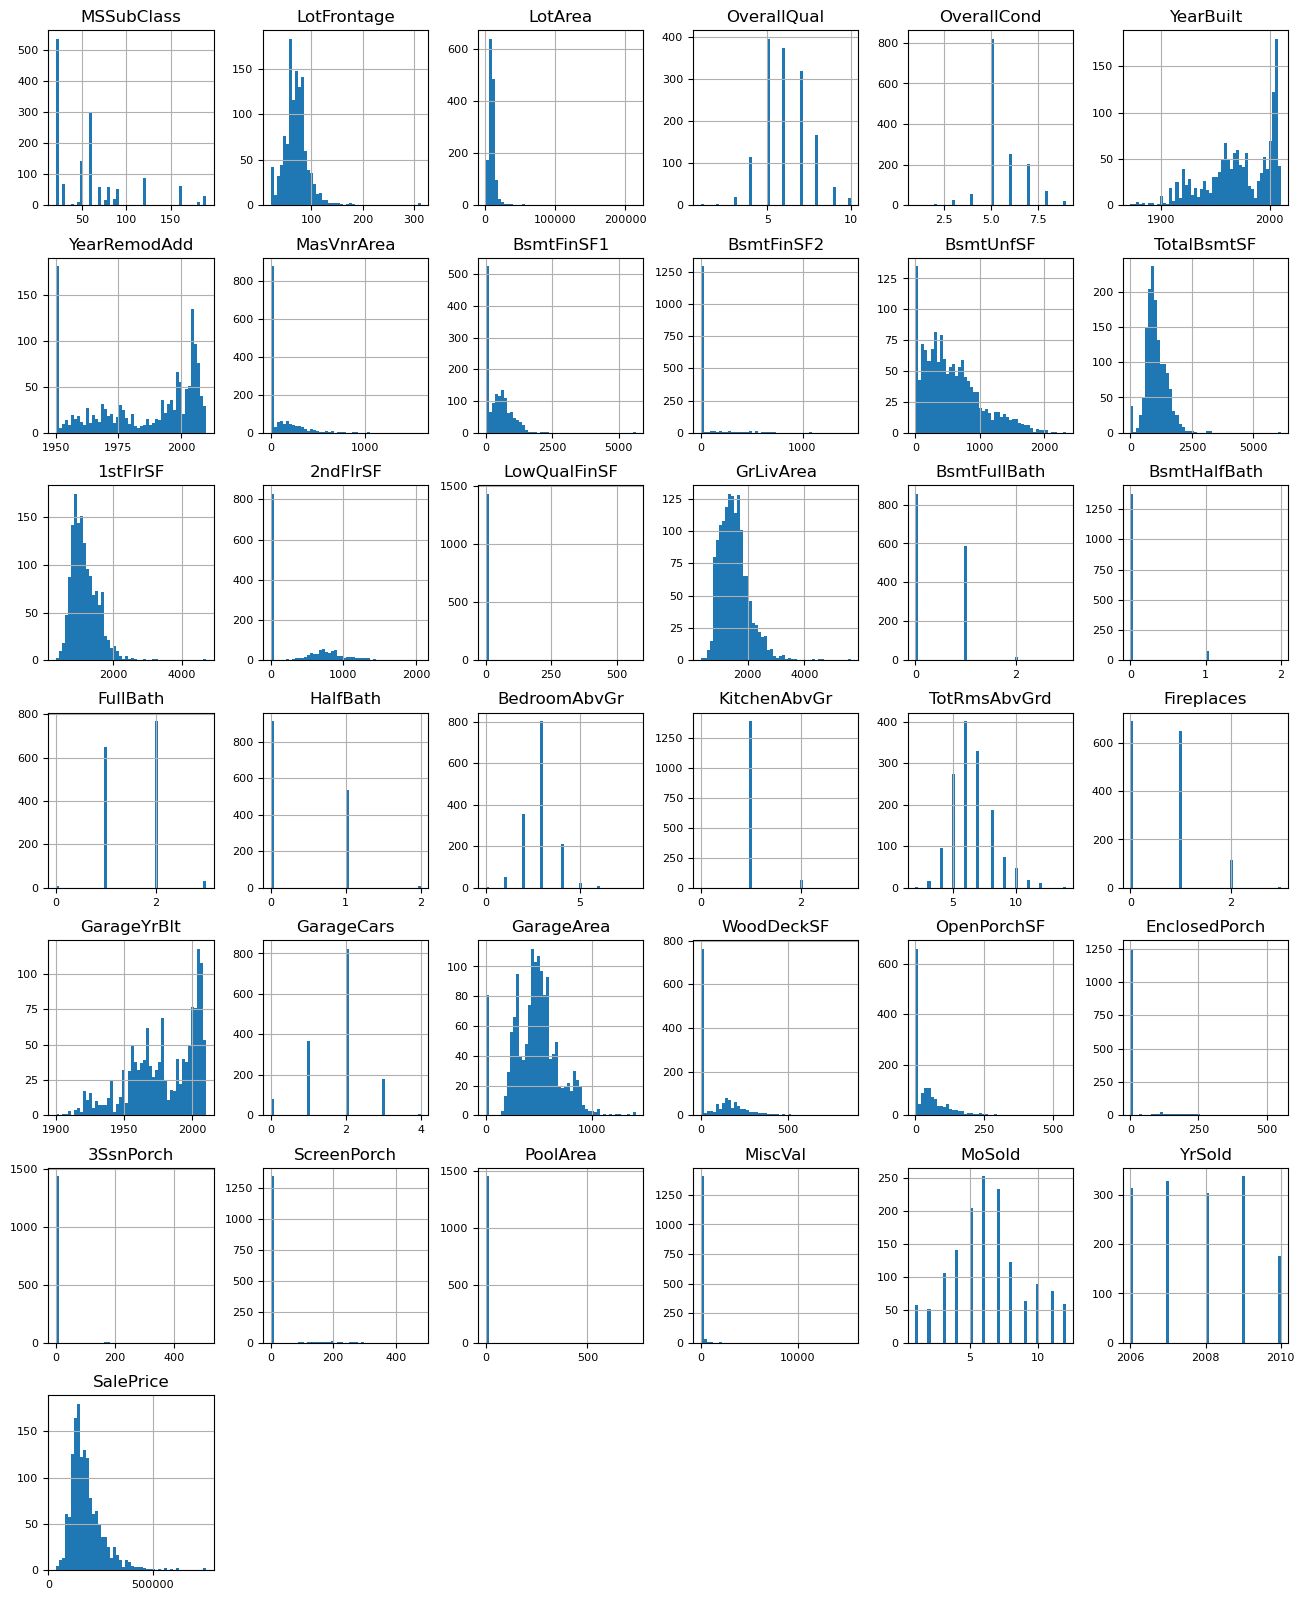

In [57]:
df_num = train_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [61]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, test_ds_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

1042 examples in training, 418 examples in testing.


In [68]:
label = 'SalePrice'
training_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
validation_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [69]:
rfm = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rfm.compile(metrics=["mse"])

Use /var/folders/2h/cw6b6gt90hg46_9n71v9kwvc0000gn/T/tmpojp541m6 as temporary training directory


In [70]:
rfm.fit(x=training_ds)


Reading training dataset...
Training dataset read in 0:00:00.336696. Found 1042 examples.
Training model...
Model trained in 0:00:00.495836
Compiling model...


[INFO 24-07-03 01:19:59.7415 EDT kernel.cc:1233] Loading model from path /var/folders/2h/cw6b6gt90hg46_9n71v9kwvc0000gn/T/tmpojp541m6/model/ with prefix 087150326a8342b2
[INFO 24-07-03 01:19:59.8485 EDT decision_forest.cc:734] Model loaded with 300 root(s), 98994 node(s), and 73 input feature(s).
[INFO 24-07-03 01:19:59.8485 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-03 01:19:59.8485 EDT kernel.cc:1061] Use fast generic engine


Model compiled.


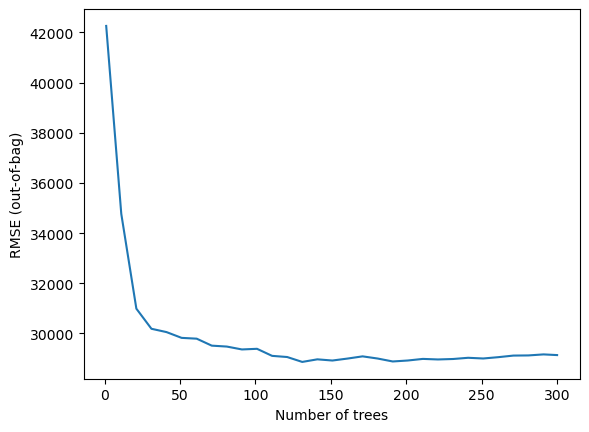

In [71]:
logs = rfm.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [72]:
inspector = rfm.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1042, accuracy=None, loss=None, rmse=29139.193558532606, ndcg=None, aucs=None, auuc=None, qini=None)

In [73]:
evaluation = rfm.evaluate(x=validation_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 950864640.0000
loss: 0.0000
mse: 950864640.0000


In [76]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 110.0),
 ("ExterQual" (4; #22), 56.0),
 ("Neighborhood" (4; #59), 42.0),
 ("GarageCars" (1; #32), 23.0),
 ("GrLivArea" (1; #38), 20.0),
 ("YearBuilt" (1; #76), 15.0),
 ("BsmtQual" (4; #14), 10.0),
 ("KitchenQual" (4; #44), 9.0),
 ("TotalBsmtSF" (1; #73), 8.0),
 ("GarageYrBlt" (1; #37), 4.0),
 ("GarageArea" (1; #31), 2.0),
 ("FullBath" (1; #29), 1.0)]

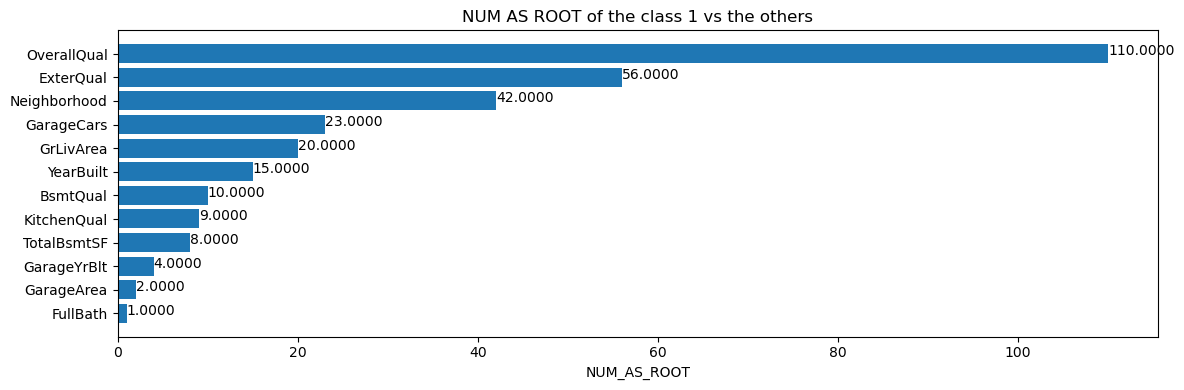

In [77]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [79]:
test_file_path = "test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rfm.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 0s 11ms/step


,Id,SalePrice
0,1461,125943.906250
1,1462,151910.734375
2,1463,177420.625000
3,1464,182142.703125
4,1465,203682.875000
